In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16

In [2]:
TRAINING_DIR = "C:/Users/yeani/Downloads/superman/images"

In [3]:
training_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=False,
    fill_mode='nearest', 
    validation_split=0.2
    )

In [4]:
training_generator = training_datagen.flow_from_directory(TRAINING_DIR, 
                                                          batch_size=128, 
                                                          target_size=(35,290), 
                                                          class_mode='categorical', 
                                                          subset='training',
                                                         )

Found 4704 images belonging to 6 classes.


In [5]:
validation_generator = training_datagen.flow_from_directory(TRAINING_DIR, 
                                                          batch_size=128, 
                                                          target_size=(35,290), 
                                                          class_mode='categorical',
                                                          subset='validation', 
                                                         )

Found 1170 images belonging to 6 classes.


오리지널 사진 파일
Found 5874 images belonging to 6 classes.
(128, 35, 290, 3) (128, 6)
[0. 1. 0. 0. 0. 0.]


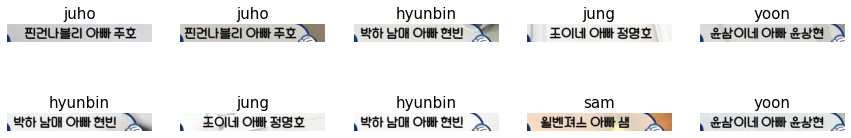

Augmentation 적용한 사진 파일
(128, 35, 290, 3) (128, 6)
[0. 1. 0. 0. 0. 0.]


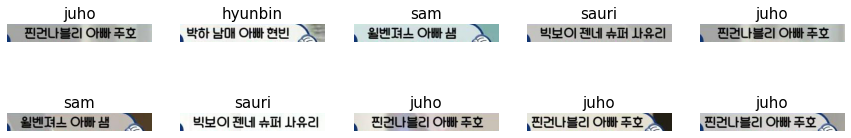

In [6]:
class_map = {
    0: 'hyunbin',
    1: 'juho',    
    2: 'jung',
    3: 'sam',
    4: 'sauri',
    5: 'yoon'
}

print('오리지널 사진 파일')

original_datagen = ImageDataGenerator(rescale=1./255)
original_generator = original_datagen.flow_from_directory(TRAINING_DIR, 
                                                          batch_size=128, 
                                                          target_size=(35,290), 
                                                          class_mode='categorical'
                                                         )

for x, y in original_generator:
    print(x.shape, y.shape)
    print(y[0])
    
    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(15, 3)
    for i in range(10):
        axes[i//5, i%5].imshow(x[i])
        axes[i//5, i%5].set_title(class_map[y[i].argmax()], fontsize=15)
        axes[i//5, i%5].axis('off')
    plt.show()
    break
    
print('Augmentation 적용한 사진 파일')
    
for x, y in training_generator:
    print(x.shape, y.shape)
    print(y[0])
    
    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(15, 3)
    for i in range(10):
        axes[i//5, i%5].imshow(x[i])
        axes[i//5, i%5].set_title(class_map[y[i].argmax()], fontsize=15)
        axes[i//5, i%5].axis('off')
    
    plt.show()
    break

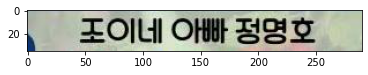

In [7]:
for x, y in original_generator:
    pic = x[:]
    break
    
plt.imshow(pic[0])

In [8]:
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(35,290, 3))
transfer_model.trainable=False

In [9]:
model = Sequential([
    transfer_model,
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax'),
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 9, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2359808   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 17,140,934
Trainable params: 2,426,246
Non-trainable params: 14,714,688
____________________________________

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [12]:
checkpoint_path = "tmp_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [13]:
epochs=25

In [14]:
history = model.fit(training_generator, 
                    validation_data=(validation_generator),
                    epochs=epochs,
                    callbacks=[checkpoint],
                    )

Epoch 1/25
37/37 [==============================] - 18s 250ms/step - loss: 0.7614 - acc: 0.7615 - val_loss: 6.5675e-05 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.00007, saving model to tmp_checkpoint.ckpt
Epoch 2/25
37/37 [==============================] - 4s 109ms/step - loss: 2.5245e-04 - acc: 1.0000 - val_loss: 1.3283e-05 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.00007 to 0.00001, saving model to tmp_checkpoint.ckpt
Epoch 3/25
37/37 [==============================] - 4s 109ms/step - loss: 5.1914e-05 - acc: 1.0000 - val_loss: 9.9184e-06 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.00001 to 0.00001, saving model to tmp_checkpoint.ckpt
Epoch 4/25
37/37 [==============================] - 4s 109ms/step - loss: 1.7163e-04 - acc: 1.0000 - val_loss: 9.3531e-06 - val_acc: 1.0000

Epoch 00004: val_loss improved from 0.00001 to 0.00001, saving model to tmp_checkpoint.ckpt
Epoch 5/25
37/37 [==============================] - 4s 110ms/step - loss: 5

In [15]:
model.load_weights(checkpoint_path)

In [16]:
model.save('superman_vgg16_model.h5')

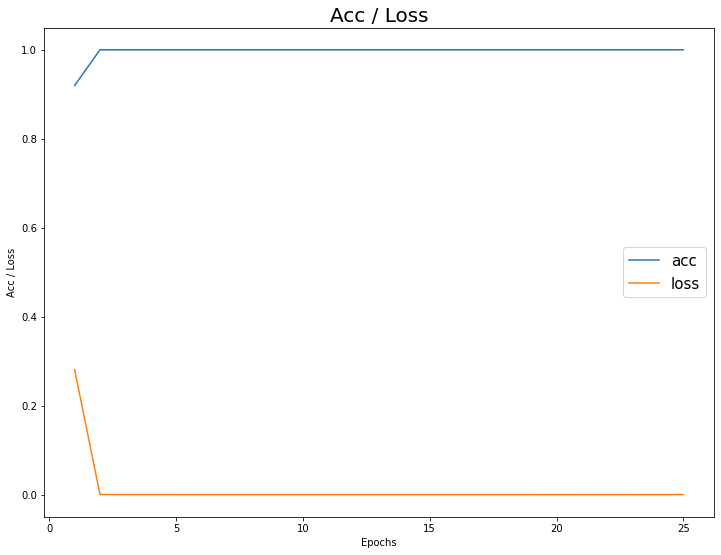

In [17]:
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, epochs+1), history.history['acc'])
plt.plot(np.arange(1, epochs+1), history.history['loss'])
plt.title('Acc / Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Acc / Loss')
plt.legend(['acc', 'loss'], fontsize=15)
plt.show()